In [1]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.filters import threshold_otsu
from skimage.transform import hough_line, hough_line_peaks
from PIL import Image 

from skimage import morphology


In [2]:
# Show the figures / plots inside the notebook
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 


In [3]:
fileName = 'imgs/test.jpg'
img = plt.imread(fileName)
img_rgb = np.copy(img)
img = rgb2gray(img)

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


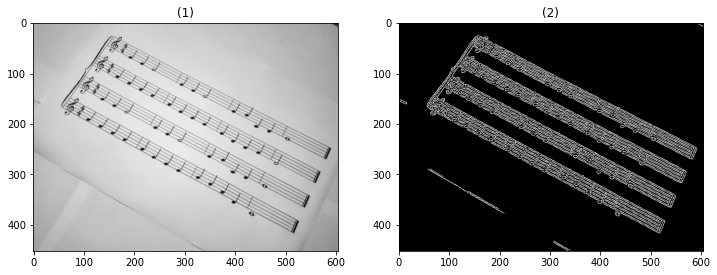

In [4]:
imgCanny = canny(img, sigma=.9)
thresh = threshold_otsu(imgCanny)
imgCanny = (imgCanny >= thresh)
show_images([img, imgCanny])

In [5]:
# Apply Hough Transform

angleSet = np.linspace(-np.pi, np.pi, 1440)  # Generates a list of 360 Radian degrees (-pi/2, pi/2)
houghArr, theta, dis = hough_line(imgCanny, angleSet)

print(theta*180/np.pi)

flatIdx = np.argmax(houghArr)
bestTheta = (flatIdx % theta.shape[0])
bestTheta = angleSet[bestTheta]
bestDis = np.int32(np.floor(flatIdx / theta.shape[0]))
bestDis = dis[bestDis]

print(bestTheta)

[-180.         -179.74982627 -179.49965254 ...  179.49965254  179.74982627
  180.        ]
-1.076306586671138


In [6]:
# Display One Line

bestLine = np.zeros(imgCanny.shape)

if bestTheta == 0:
    for y in range(imgCanny.shape[0]):
        bestLine[y, bestDis] = 1
else:
    for x in range(bestLine.shape[1]):
        y = (bestDis - x*np.cos(bestTheta))/np.sin(bestTheta)
        y = np.int32(np.floor(y))
        if y < bestLine.shape[0] and y >= 0:
            bestLine[y, x] = 1
        else:
            pass

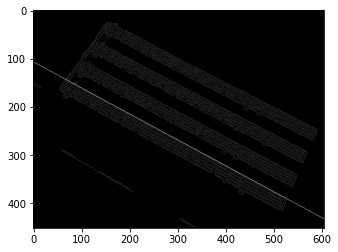

In [7]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
        
axes.imshow(imgCanny)
axes.imshow(bestLine, alpha=0.8)
plt.show()

lineAboveImgCanny = np.maximum(imgCanny,bestLine)

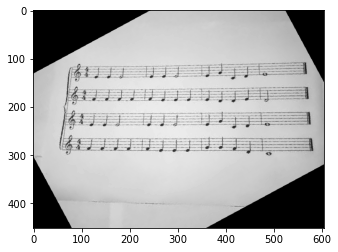

In [8]:
# Rotate with Theta
def rotate_by_theta(IMG, T):
    return_img = np.copy(IMG)
    pil_img = Image.fromarray(np.int8(return_img*255)).convert('RGB')
    pil_img = pil_img.rotate(T)
    return_img = np.asarray(pil_img)
    return return_img

thetaRotateDeg = (bestTheta*180)/np.pi
if thetaRotateDeg > 0 :
    thetaRotateDeg = thetaRotateDeg - 90
else : 
    thetaRotateDeg = thetaRotateDeg + 90
imgRotated = rgb2gray(rotate_by_theta(img, thetaRotateDeg))

plt.imshow(imgRotated)
plt.show()


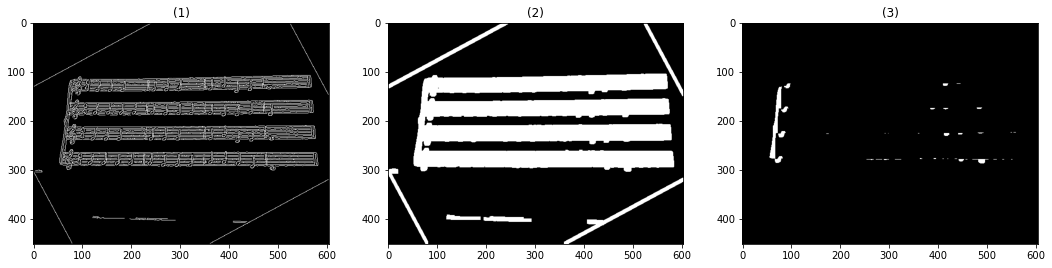

In [15]:
# Next 2 cells are not much accurate. Trying to fix the case of Skewing with angle > 90

x = rgb2gray(np.copy(imgRotated))
x = canny(x)
x = (x >= thresh)

flt = np.ones([7, 5])
dil = morphology.binary_dilation(x, flt)

flt2 = np.ones([35, 3])

er = morphology.erosion(dil, flt2)


show_images([x, dil, er])

72


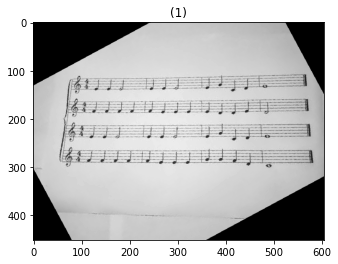

In [16]:
def get_max_vertical_hist_col(img):
    tmp = np.copy(img)
    maxi=0
    col=0
    for i in range(tmp.shape[1]):
        current_sum=0
#         for j in range(tmp.shape[0]):
#             current_sum += tmp[j][i]
        current_sum = np.sum(tmp[:, i])
        if maxi < current_sum:
            maxi = current_sum
            col = i
    return col

thick_col = get_max_vertical_hist_col(er)

print(thick_col)

if thick_col > img.shape[1]/2:
    imgRotated = rgb2gray(rotate_by_theta(imgRotated, 180))

show_images([imgRotated])